##### Packages

In [1]:
using Plots, DifferentialEquations, Distributions, Random, LaTeXStrings, DataFrames, GLM, StatsPlots

##### Start defining parameters and first functions 

In [2]:
function CR!(dx,x,p,t)

    N,M,R = p
    dx[1:N] = x[1:N].*(R*x[1+N:N+M])
    dx[N+1:N+M] = -x[1+N:N+M].*(transpose(R)*x[1:N]) 
    
end
 
function random_mat(N,M,S,Amag)

    A = rand(Float64, N*M);
    A[A .< S] .= 0;
    A = reshape(A, (N,M));
    return A*Amag*N*M*M/sum(A)

end

function Y0s_fun(M,k,σ,steps,Ymag)
  
    Y0 = rand(M);
    Y0 /= sum(Y0);
    Y0 *= Ymag;

    Y0s = zeros((M,steps));
    Y0s[:,1] = Y0;

    for i in 2:steps
        tmp = Y0s[:,i-1] + σ*randn(M).*Y0 - k*(Y0s[:,i-1] - Y0)
        Y0s[:,i] = @. abs(tmp)
    end
    return Y0s
end

function Y0s_fun1(M,σ,steps,Y0)
  
    Y0s = zeros((M,steps));
    Y0s[:,1] .= Y0;

    for i in 2:steps
        tmp = Y0 .+ σ*randn(M)*Y0
        Y0s[:,i] = @. abs(tmp)
    end
    return Y0s
end

function final_cond(s)
    X0j = transpose(hcat([s[j][end,:] for j in 1:length(s)]...))
    return X0j./D
end

final_cond (generic function with 1 method)

In [3]:
function finds(N,M,R,D,steady_threshold,steps,tspanf,Y0s;ss=true)
    p = [N,M,R]
    tspan = (0.,tspanf)
    X0s = zeros((N,steps+1));
    X0s[:,1] = ones(N)/N*100;
    # X0s[:,1] = ones(N)/N*0.005;
    X0s[:,1] ./= D
    sol = [[] for i=1:steps]
    res = [[] for i=1:steps]
    time_series = [[] for i=1:steps]
    sol_mat = Matrix{Float64}[]
    res_mat = Matrix{Float64}[]
    flag = 0 
    # this flag variable allows me to print only once the fact that the steady state has been reached inside the loop 
    # and then it is updated to one in order not to satisfy the condition for the print anymore
    steady_steps = 0
    
    for  j in 1:steps 
        X0 = X0s[:,j]
        Y0 = Y0s[:,j]
        XY0 = vcat(X0,Y0)

        prob = ODEProblem(CR!, XY0, tspan, p)#, callback = aborted_res)
        sol_tmp = solve(prob,Tsit5(),reltol=1e-7);

        X0s[:,j+1] = sol_tmp.u[length(sol_tmp.u)][1:N]./D

        if ss == true && sum(abs.((X0s[:,j+1]./X0s[:,j]) .- 1).< steady_threshold) == length(X0) && flag == 0
            print("The approximate steady state has been reached in ",j," steps")
            flag = 1
            steady_steps = j
        end
        
        sol[j] = sol_tmp.u
        res[j] = sol_tmp.u
        sol[j] = [sol[j][i][1:N] for i in 1:length(sol[j])]
        res[j] = [res[j][i][N+1:(N+M)] for i in 1:length(res[j])]
        time_series[j] = sol_tmp.t
        
        tmp = zeros(length(sol[j]),N)
        for i in 1:length(sol[j])
            tmp[i,:] = sol[j][i]
        end
        push!(sol_mat,tmp)

        tmp_res = zeros(length(res[j]),M)
        for i in 1:length(res[j])
            tmp_res[i,:] = res[j][i]
        end
        push!(res_mat,tmp_res)
    end

    filt = [i for i in 1:length(sol) if sol[i] != []]  
    time_series = time_series[filt]

    return [sol_mat,res_mat,steady_steps],time_series

end

finds (generic function with 1 method)

In [4]:
function gen_D(Ȳ,tspanf,R)
    D_min = exp(Ȳ*tspanf*R)
    return D_min .- modf.(D_min)[1][1]
end

gen_D (generic function with 1 method)

In [34]:
# plot() function represents, starting from a matrix with NxM dimension, each column against the indices 
# coming from the length of those columns. We end up then with M lines.

#---Parameters of the simulation---

N = 1 
M = 1
S = 0.1
σ = 0.2
k = 1
D = 2
Amag = 10 
Ymag = 100
Ȳ = 100
steps = 5000
tspanf = 0.0007
steady_threshold = 0.01

# Y0j = Y0s_fun(M,k,σ,steps,Ymag)
Y0j = Y0s_fun1(M,σ,steps,Ȳ)
# Y0j = transpose(ones(steps).* Ȳ) # if Y0j are equal for each species and for each dilution step 
R = random_mat(N,M,S,Amag);
# D = gen_D(Ȳ,tspanf,R);

Let's see how many dilution steps are necessary to reach the approximate steady state 

In [35]:
sr,t = finds(N,M,R,D,steady_threshold,steps,tspanf,Y0j)
s = sr[1]
if sr[3] != 0 
    steady_steps = sr[3]
else
    steady_steps = 1
end
X0j = final_cond(s);

The approximate steady state has been reached in 2 steps

In the case of more than one species and one resource we can set the steady solutions to be the ones that are not extinguished after the `steps` of dilution provided by input

In [9]:
ab_thresh = 10e-2
bad_index = findall(X0j .< ab_thresh)
# bad_index = findall(X0j .== ab_thresh)
rmv_index = [Set([bad_index[i][2] for i in 1:length(bad_index)])...]
# these are the columns whose species go to zero, or at least that reach to 10e-30 abundances after some dilution steps
# that is they are going to be extinguished soon
X0j = X0j[:,[i for i in 1:N if i ∉ rmv_index]];

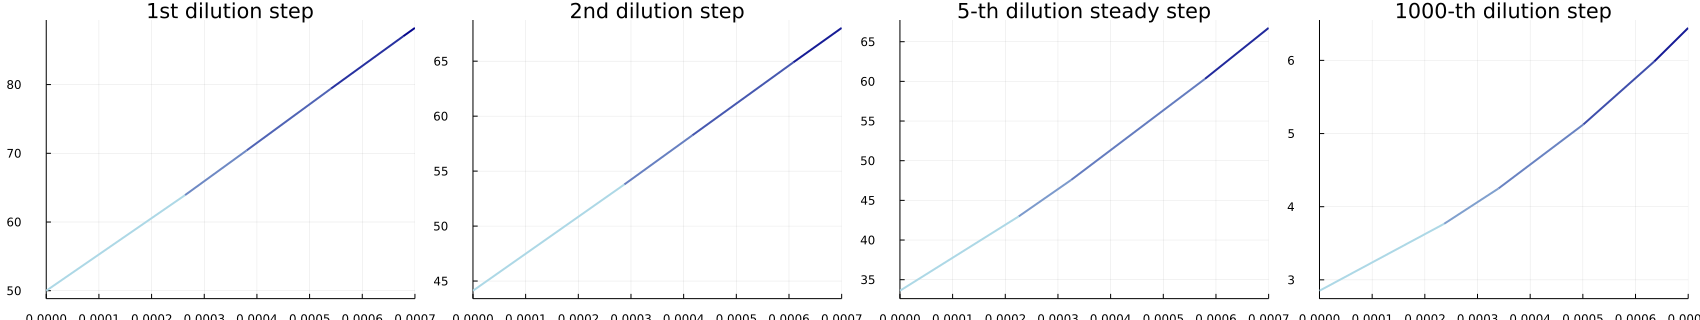

In [10]:
if steady_steps != 2
    p1 = plot(t[1],s[1],legend=false,color=:blues,line_z=s[1],xlim=(0,tspanf),title="1st dilution step")
    p2 = plot(t[2],s[2],legend=false,color=:blues,line_z=s[2],xlim=(0,tspanf),title="2nd dilution step")
    p3 = plot(t[steady_steps],s[steady_steps],legend=false,color=:blues,line_z=s[steady_steps],xlim=(0,tspanf),
            title="$steady_steps-th dilution steady step")
    p4 = plot(t[1000],s[1000],legend=false,color=:blues,line_z=s[end],xlim=(0,tspanf),title="1000-th dilution step")
        
    plot(p1,p2,p3,p4,layout=(1,4),size=(1700,320),linewidth=2,linestyle=:solid)
else 
    p1 = plot(t[1],s[1],legend=false,color=:blues,line_z=s[1],xlim=(0,tspanf),title="1st dilution step")
    p3 = plot(t[steady_steps],s[steady_steps],legend=false,color=:blues,line_z=s[steady_steps],xlim=(0,tspanf),
            title="$steady_steps-nd dilution steady step")
    p4 = plot(t[1000],s[1000],legend=false,color=:blues,line_z=s[end],xlim=(0,tspanf),title="1000-th dilution step")
        
    plot(p1,p3,p4,layout=(1,3),size=(1200,400),linewidth=2,linestyle=:solid)
end

# savefig("one_s_r_evolution_short.png")

In [38]:
# plot([mean(X0j[:,i]) for i in 1:size(X0j)[2]],linetype=:hline,linewidth=3.5,linestyle=:dash,label="Mean of the survived species",color=:grey)
plot(X0j,legend=false,size=(800,500),linewidth=1,xlim=(0,2000),yaxis=:log,
     xlabel="Dilution steps",ylabel="Final species abundances "*L" X_T^k",label="",thickness_scaling=1.5,color=:dodgerblue)
plot!([steady_steps],linetype=:vline,linewidth=2.5,linestyle=:dash,color=:black,
      label="$steady_steps steps to approx steady state",
      legend=:topleft)
savefig("one_s_r_timeseries_short.png")

In [39]:
X0j_norm = [X0j[steady_steps:end,i] .- mean(X0j[steady_steps:end,i]) for i in 1:size(X0j)[2]]
histogram(X0j[steady_steps:end,:],normalize=:pdf,legend=false,
          xlabel="Final species abundances "*L"X_T^*", ylabel=L"p(X_T^*)",size=(800,500),thickness_scaling=1.5,color=:blue)
density!(X0j[steady_steps:end,:],normalize=:pdf,linewidth=3,color=:dodgerblue)
savefig("one_s_r_distribution_short.png")

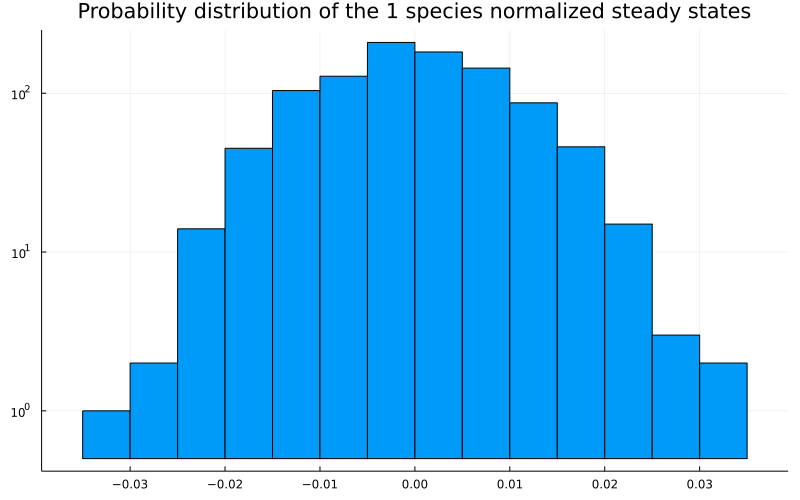

In [56]:
histogram(X0j_norm,density=:true,legend=false,yaxis=:log,
          title="Probability distribution of the $N species normalized steady states", size=(800,500))